In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer,OneHotEncoder,StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor


import warnings
warnings.filterwarnings('ignore')

In [2]:
path = 'https://frenzy86.s3.eu-west-2.amazonaws.com/IFAO/boston_houses.csv'

df = pd.read_csv(path)
df = df.rename(columns={"MEDV":"Price"})
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


<Axes: >

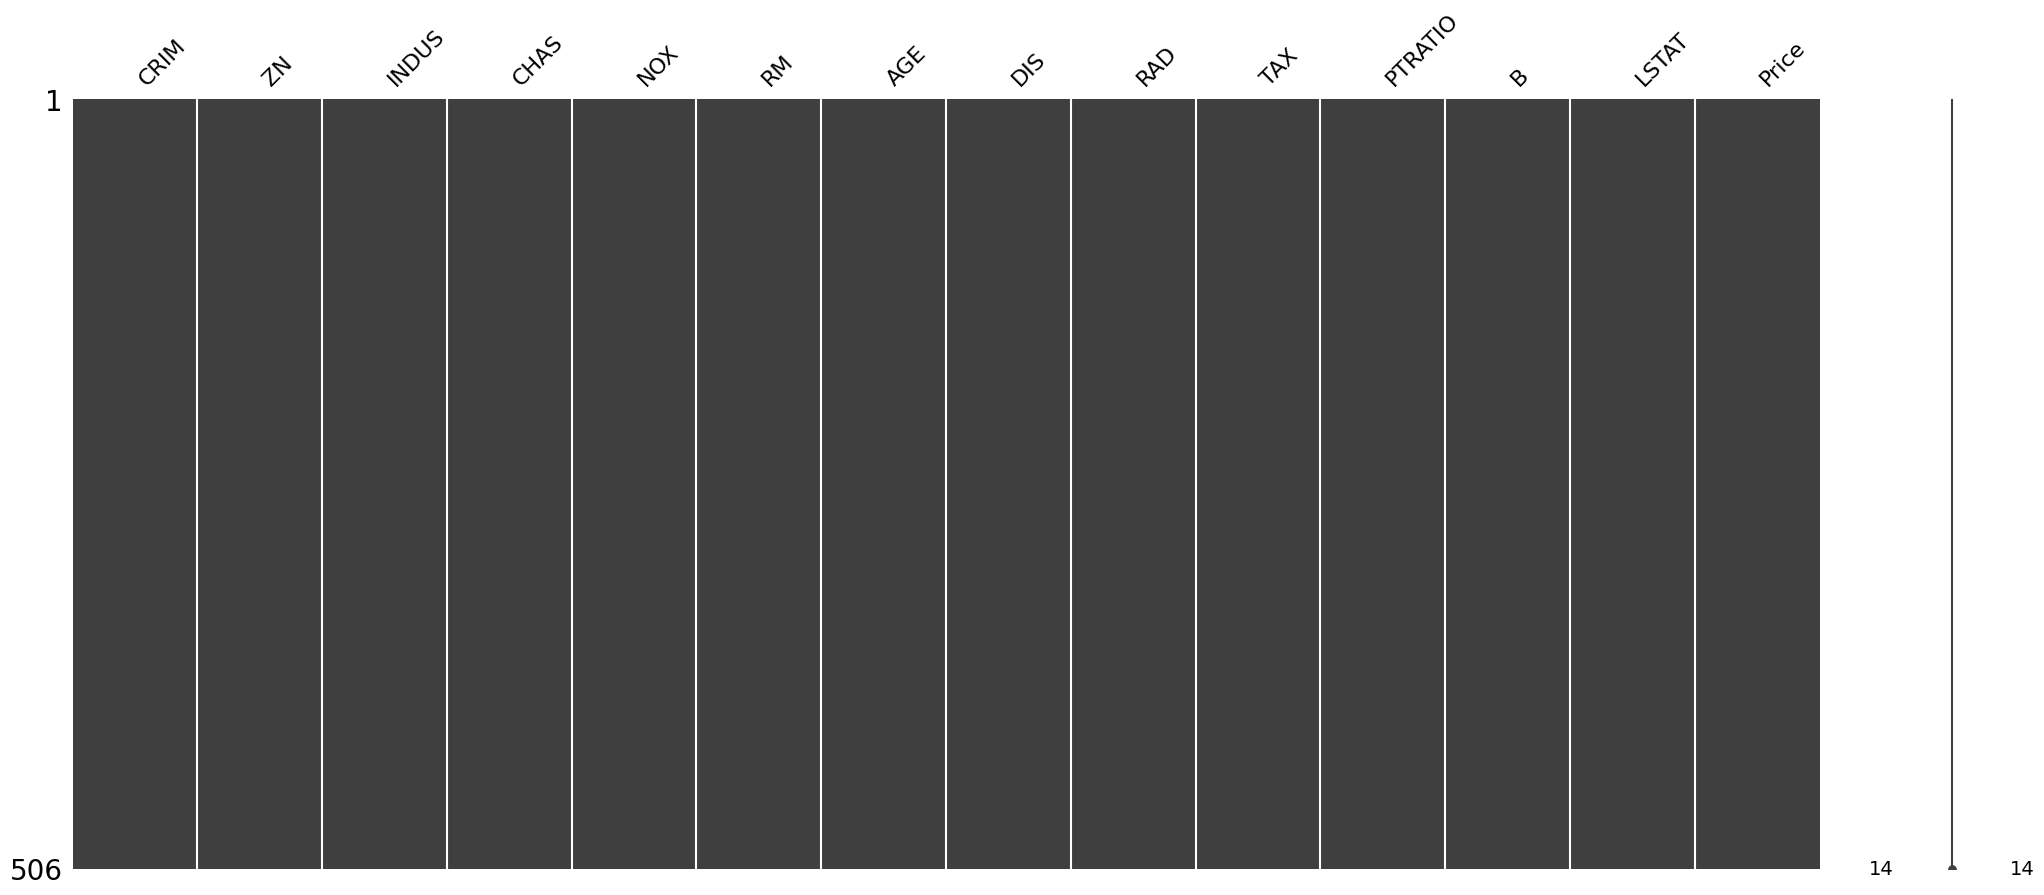

In [3]:
import missingno as msno
msno.matrix(df)

In [4]:
#STEP 0 FILTERING
#remove features not useful
df_clean = df[['CRIM', 'NOX', 'RM', 'DIS', 'PTRATIO', 'LSTAT','Price']]

In [ ]:
# STEP 1 - TRAIN TEST SPLITTING
#Feature matrix and target vector
X = df_clean.drop(['Price'], axis=1) # matrice Features
y = df_clean['Price']                #Target

## Simple Imputer
https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html

Il SimpleImputer è utilizzato per gestire i valori mancanti (NaN) all'interno dei dati. Nella tua pipeline, viene utilizzato per imputare i valori mancanti nelle feature numeriche, sostituendoli con la mediana dei valori presenti in quella colonna.

Ad esempio, supponiamo di avere una feature numerica come l'età di una persona e alcuni valori sono mancanti. Utilizzando SimpleImputer(strategy='median'), verranno sostituiti i valori mancanti con la mediana dell'età di tutte le altre persone.

Questo aiuta a mantenere la completezza dei dati durante l'analisi, poiché molti algoritmi di machine learning non possono gestire direttamente i valori mancanti.

- Se impostato su "mean", sostituisce i valori mancanti utilizzando la media lungo ciascuna colonna. Può essere utilizzato solo con dati numerici.

- Se impostato su "median", sostituisce i valori mancanti utilizzando la mediana lungo ciascuna colonna. Può essere utilizzato solo con dati numerici.

- Se impostato su "most_frequent", sostituisce i valori mancanti utilizzando il valore più frequente lungo ciascuna colonna. Può essere utilizzato con dati di tipo stringa o numerici. Se ci sono più valori più frequenti, viene restituito solo il più piccolo.

- Se impostato su "constant", sostituisce i valori mancanti con il valore specificato in fill_value. Può essere utilizzato con dati di tipo stringa o numerici.



In [ ]:
X.columns

Index(['CRIM', 'NOX', 'RM', 'DIS', 'PTRATIO', 'LSTAT'], dtype='object')

In [ ]:
## dividiamo automaticamente le features numeriche da quelle categoriche

numerical_features = [x for x, dtype in zip(X.columns, X.dtypes) if dtype.kind in ['i','f'] ]
categorical_features = [x for x, dtype in zip(X.columns, X.dtypes) if dtype.kind not in ['i','f']]

print('Numerical : ' + str(numerical_features))
print('Categorical : ' + str(categorical_features))

Numerical : ['CRIM', 'NOX', 'RM', 'DIS', 'PTRATIO', 'LSTAT']
Categorical : []


In [ ]:
## Parte di processingdata: Cleaning, fill Nan + OHE
Preprocessor = make_column_transformer(
                                        (make_pipeline(
                                        SimpleImputer(strategy = 'median'),
                                        KBinsDiscretizer(n_bins=3)), numerical_features),

                                        (make_pipeline(
                                        #FunctionTransformer(lambda x: np.where(x == 'n.d.', np.nan, x)),
                                        SimpleImputer(strategy = 'constant', fill_value = 'missing'),
                                        OneHotEncoder(categories = 'auto', handle_unknown = 'ignore')), categorical_features)
                                        )

In [ ]:
scaler = StandardScaler()

regressor = GradientBoostingRegressor(
                                        learning_rate=0.1,
                                        max_depth=3,
                                        min_samples_split=10,
                                        n_estimators=100
                                        )

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

model_pipe = Pipeline([
                       ('Preprocessing features', Preprocessor),
                       ('Scaling and standadize data', scaler),
                       ('Regressor', regressor)
                      ])
model_pipe

Pipeline(steps=[('Preprocessing features',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('kbinsdiscretizer',
                                                                   KBinsDiscretizer(n_bins=3))]),
                                                  ['CRIM', 'NOX', 'RM', 'DIS',
                                                   'PTRATIO', 'LSTAT']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('Scaling and standadize data', StandardScaler()),
                ('Regressor', GradientBoostingRegressor(min_samples_split=10))])

In [ ]:
model_pipe.fit(X, y)

Pipeline(steps=[('Preprocessing features',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('kbinsdiscretizer',
                                                                   KBinsDiscretizer(n_bins=3))]),
                                                  ['CRIM', 'NOX', 'RM', 'DIS',
                                                   'PTRATIO', 'LSTAT']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('Scaling and standadize data', StandardScaler()),
                ('Regressor', GradientBoostingRegressor(min_samples_split=10))])

In [ ]:
y_pred_tot = model_pipe.predict(X)

In [ ]:
cross_val_scores = cross_val_score(model_pipe, X, y, cv=5)
print(cross_val_scores)

# Calcola la media e la deviazione standard dei punteggi
mean_score = np.mean(cross_val_scores)
std_score = np.std(cross_val_scores)

print(f"Mean R2score cross-validation score:{mean_score:.2f}")
print(f"Standard deviation of cross-validation scores:{std_score:.2f}")

[ 0.49783037  0.63810412 -0.03160184  0.31272768 -0.10677473]
Mean R2score cross-validation score:0.26
Standard deviation of cross-validation scores:0.29


##Fit the model with entire dataset

<img src='https://frenzy86.s3.eu-west-2.amazonaws.com/python/cross.png' width=600>


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

r2_score(y, y_pred_tot)
mean_squared_error(y, y_pred_tot, squared=False)
mean_squared_error(y, y_pred_tot)
mean_absolute_error(y, y_pred_tot)

3.158862110231327

## Prediction of single observation

In [ ]:
X.columns

Index(['CRIM', 'NOX', 'RM', 'DIS', 'PTRATIO', 'LSTAT'], dtype='object')

In [ ]:
X.iloc[0]

CRIM        0.00632
NOX         0.53800
RM          6.57500
DIS         4.09000
PTRATIO    15.30000
LSTAT       4.98000
Name: 0, dtype: float64

In [ ]:
CRIM = 0.00632
NOX = 0.53800
RM  = 6.57500
DIS = 4.09000
PTRATIO = 15.30000
LSTAT = 4.98000

data = {
        "CRIM": [CRIM],
        "NOX": [NOX],
        "RM": [RM],
        "DIS":[DIS],
        "PTRATIO": [PTRATIO],
        "LSTAT": [LSTAT],
        }

input_df = pd.DataFrame(data)
res = model_pipe.predict(input_df).astype(int)[0]
print(res)

31


In [ ]:
import joblib

joblib.dump(model_pipe,'bostonpipe.pkl')

['bostonpipe.pkl']

## Load model .pkl

In [ ]:
import joblib

model_pipe = joblib.load('bostonpipe.pkl')
print('Model loaded successfully')

Model loaded successfully


In [ ]:
model_pipe

Pipeline(steps=[('Preprocessing features',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('kbinsdiscretizer',
                                                                   KBinsDiscretizer(n_bins=3))]),
                                                  ['CRIM', 'NOX', 'RM', 'DIS',
                                                   'PTRATIO', 'LSTAT']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('Scaling and standadize data', StandardScaler()),
                ('Regressor', GradientBoostingRegressor(min_samples_split=10))])